In [1]:
#ライブラリをインポート
#標準ライブラリ
import random
import pathlib

#サードパーティー製
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import timm
import torchinfo
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.metrics import(
    accuracy_score,
    ConfusionMatrixDisplay, confusion_matrix

)

#自作モジュール
from utils.Module import *

#乱数シードの設定
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
print(torch.__version__)

1.13.1


In [3]:
size = 30

# 概要

SwinTransformerを使用して、果物の分類モデルを作成する．<br>
基本的にはhttps://github.com/YutaroOgawa/pytorch_advanced/blob/master/1_image_classification/1-3_transfer_learning.ipynb
からコピペしている．

## 画像群を取得

In [4]:
#訓練画像のパス
list_train_path = list(pathlib.Path("Train").iterdir())
list_train_path = [str(path) for path in list_train_path]#str化

#推論画像のパス
list_val_path = list(pathlib.Path("Val").iterdir())
list_val_path = [str(path) for path in list_val_path]#str化

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

## 適用する水増し処理

In [6]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize((size, size)), 
                transforms.ToTensor(),  # テンソルに変換
            ]),
            'val': transforms.Compose([
                transforms.Resize((size, size)),  # リサイズ
                transforms.ToTensor(),  # テンソルに変換
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

## データセットを作成

In [7]:
class Dataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])
        
        # 画像のラベルをファイル名から抜き出す
        if(self.phase == "train"):
          label = list(pd.DataFrame(list_train_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]
        else:
          label = list(pd.DataFrame(list_val_path).iloc[:, 0].str.split("\\", expand = True).iloc[:, -1].str.split("_", expand = True).iloc[:, 0])[index]


        # ラベルを数値に変更する
        if label == "apple":
            label = 0
        elif label == "tomato":
            label = 1
        elif label == "cherry":
            label = 2

        return img_transformed, label

In [8]:
# 実行
train_dataset = Dataset(
    file_list=list_train_path, transform=ImageTransform(size), phase='train')

val_dataset = Dataset(
    file_list=list_val_path, transform=ImageTransform(size), phase='val')

## DataLoaderの作成

In [9]:
# ミニバッチのサイズを指定
batch_size = 64

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

## モデルをロード

In [28]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cbr_1 = conv2DBatchNormRelu(
            3, 16, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_2 = conv2DBatchNormRelu(
            16, 32, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.cbr_3 = conv2DBatchNormRelu(
            32, 64, kernel_size=3, stride=1, padding=1, dilation=1, bias=True)
        self.maxpool2d = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv = nn.Conv2d(64, 3, 1, stride = 1)
        self.flatten = nn.Flatten()     
        self.sigmoid = nn.Sigmoid()
        self.global_avg = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        #畳み込み層
        x = self.maxpool2d(self.cbr_1(x))
        x = self.maxpool2d(self.cbr_2(x))
        x = self.maxpool2d(self.cbr_3(x))
        
        #全結合層
        x = self.flatten(self.global_avg(self.sigmoid(self.conv(x))))
        
        return x

In [29]:
model = Model()

In [30]:
torchinfo.torchinfo.summary(
    model,
    input_size=(batch_size, 3, 30, 30),
    col_names=["output_size", "num_params"],
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 3]                   --
├─conv2DBatchNormRelu: 1-1               [64, 16, 30, 30]          --
│    └─Conv2d: 2-1                       [64, 16, 30, 30]          448
│    └─BatchNorm2d: 2-2                  [64, 16, 30, 30]          32
│    └─ReLU: 2-3                         [64, 16, 30, 30]          --
│    └─Dropout2d: 2-4                    [64, 16, 30, 30]          --
├─MaxPool2d: 1-2                         [64, 16, 15, 15]          --
├─conv2DBatchNormRelu: 1-3               [64, 32, 15, 15]          --
│    └─Conv2d: 2-5                       [64, 32, 15, 15]          4,640
│    └─BatchNorm2d: 2-6                  [64, 32, 15, 15]          64
│    └─ReLU: 2-7                         [64, 32, 15, 15]          --
│    └─Dropout2d: 2-8                    [64, 32, 15, 15]          --
├─MaxPool2d: 1-4                         [64, 32, 7, 7]            --
├─conv2DBat

## 損失関数の定義

In [13]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

## 最適化手法を設定

In [14]:
# 最適化手法の設定
optimizer = optim.Adadelta(model.parameters())

## 学習と検証を実施

In [15]:
#decice = "cuda:0"
decice = "cpu"

In [16]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
    #モデルをGPUへ
    net.to(decice)
    #lossを保存
    list_train_loss = []
    list_val_loss = []
    #正解率を保存
    list_train_acc = []
    list_val_acc = []

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):
                #GPUへ
                inputs = inputs.to(decice)
                labels = labels.to(decice)
                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            
            #訓練の場合
            if(phase == "train"):
                list_train_loss.append(epoch_loss)
                list_train_acc.append(epoch_acc)
            #推論の場合
            else:
                list_val_loss.append(epoch_loss)
                list_val_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
    torch.save(net.state_dict(), 'model_weight.pth')
            
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [17]:
# 学習・検証を実行する
num_epochs=50
list_train_loss, list_train_acc, list_val_loss, list_val_acc = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.50it/s]


val Loss: 1.0987 Acc: 0.3624
Epoch 2/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 1.0436 Acc: 0.4855


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.51it/s]


val Loss: 1.0941 Acc: 0.3652
Epoch 3/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.04it/s]


train Loss: 0.9966 Acc: 0.5485


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.49it/s]


val Loss: 0.9858 Acc: 0.5800
Epoch 4/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.16it/s]


train Loss: 0.9710 Acc: 0.5706


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.51it/s]


val Loss: 0.9163 Acc: 0.6538
Epoch 5/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


train Loss: 0.9562 Acc: 0.5866


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:27<00:00,  1.18it/s]


val Loss: 0.9157 Acc: 0.6567
Epoch 6/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.09s/it]


train Loss: 0.9276 Acc: 0.6236


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:28<00:00,  1.17it/s]


val Loss: 0.8854 Acc: 0.7033
Epoch 7/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.9083 Acc: 0.6567


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.53it/s]


val Loss: 0.8767 Acc: 0.6962
Epoch 8/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.9045 Acc: 0.6517


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.59it/s]


val Loss: 0.8785 Acc: 0.6895
Epoch 9/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.9005 Acc: 0.6627


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.51it/s]


val Loss: 0.8793 Acc: 0.6924
Epoch 10/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.8899 Acc: 0.6697


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.56it/s]


val Loss: 0.9019 Acc: 0.6110
Epoch 11/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.8906 Acc: 0.6567


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.55it/s]


val Loss: 0.8355 Acc: 0.7505
Epoch 12/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.8875 Acc: 0.6717


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.56it/s]


val Loss: 0.8556 Acc: 0.7233
Epoch 13/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.03it/s]


train Loss: 0.8792 Acc: 0.6797


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.59it/s]


val Loss: 0.8293 Acc: 0.7376
Epoch 14/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.8830 Acc: 0.6617


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.56it/s]


val Loss: 0.8329 Acc: 0.7257
Epoch 15/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8795 Acc: 0.6837


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.56it/s]


val Loss: 0.8682 Acc: 0.6667
Epoch 16/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.8652 Acc: 0.6907


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.54it/s]


val Loss: 0.8410 Acc: 0.7238
Epoch 17/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.8673 Acc: 0.6787


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.48it/s]


val Loss: 0.8077 Acc: 0.7748
Epoch 18/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


train Loss: 0.8698 Acc: 0.6907


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.53it/s]


val Loss: 0.8024 Acc: 0.7767
Epoch 19/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.00s/it]


train Loss: 0.8615 Acc: 0.6847


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.57it/s]


val Loss: 0.8819 Acc: 0.6638
Epoch 20/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.8495 Acc: 0.7107


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.60it/s]


val Loss: 0.8391 Acc: 0.7081
Epoch 21/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.8554 Acc: 0.6987


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:19<00:00,  1.66it/s]


val Loss: 0.8918 Acc: 0.6490
Epoch 22/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.11s/it]


train Loss: 0.8599 Acc: 0.6987


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.54it/s]


val Loss: 0.8022 Acc: 0.7619
Epoch 23/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8463 Acc: 0.7127


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.54it/s]


val Loss: 0.8281 Acc: 0.7210
Epoch 24/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.12it/s]


train Loss: 0.8383 Acc: 0.7177


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.55it/s]


val Loss: 0.7890 Acc: 0.7871
Epoch 25/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.13it/s]


train Loss: 0.8409 Acc: 0.7237


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.58it/s]


val Loss: 0.7904 Acc: 0.7719
Epoch 26/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.8349 Acc: 0.7297


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.59it/s]


val Loss: 0.7936 Acc: 0.7733
Epoch 27/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.8457 Acc: 0.7147


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.59it/s]


val Loss: 0.8638 Acc: 0.6810
Epoch 28/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.05s/it]


train Loss: 0.8488 Acc: 0.7017


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.62it/s]


val Loss: 0.8466 Acc: 0.6976
Epoch 29/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.8399 Acc: 0.7317


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.57it/s]


val Loss: 0.8025 Acc: 0.7557
Epoch 30/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.8184 Acc: 0.7467


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.56it/s]


val Loss: 0.7786 Acc: 0.7995
Epoch 31/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:17<00:00,  1.08s/it]


train Loss: 0.8285 Acc: 0.7197


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.56it/s]


val Loss: 0.8329 Acc: 0.7252
Epoch 32/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.02it/s]


train Loss: 0.8218 Acc: 0.7437


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.50it/s]


val Loss: 0.8364 Acc: 0.7052
Epoch 33/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.04s/it]


train Loss: 0.8309 Acc: 0.7267


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.55it/s]


val Loss: 0.7821 Acc: 0.7933
Epoch 34/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.14it/s]


train Loss: 0.8173 Acc: 0.7397


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.48it/s]


val Loss: 0.7760 Acc: 0.7952
Epoch 35/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


train Loss: 0.8143 Acc: 0.7287


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.55it/s]


val Loss: 0.7899 Acc: 0.7748
Epoch 36/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8298 Acc: 0.7237


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.59it/s]


val Loss: 0.8031 Acc: 0.7657
Epoch 37/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.8206 Acc: 0.7427


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.55it/s]


val Loss: 0.7834 Acc: 0.7814
Epoch 38/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


train Loss: 0.8216 Acc: 0.7337


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.60it/s]


val Loss: 0.8294 Acc: 0.7248
Epoch 39/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.02s/it]


train Loss: 0.8071 Acc: 0.7558


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.58it/s]


val Loss: 0.8082 Acc: 0.7490
Epoch 40/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.05it/s]


train Loss: 0.8165 Acc: 0.7477


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.58it/s]


val Loss: 0.8023 Acc: 0.7643
Epoch 41/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.01s/it]


train Loss: 0.8115 Acc: 0.7427


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:21<00:00,  1.51it/s]


val Loss: 0.7817 Acc: 0.7843
Epoch 42/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:16<00:00,  1.03s/it]


train Loss: 0.8088 Acc: 0.7558


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:20<00:00,  1.59it/s]


val Loss: 0.8555 Acc: 0.6790
Epoch 43/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


train Loss: 0.8161 Acc: 0.7447


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.45it/s]


val Loss: 0.7601 Acc: 0.8129
Epoch 44/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.07it/s]


train Loss: 0.8078 Acc: 0.7497


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:22<00:00,  1.45it/s]


val Loss: 0.7645 Acc: 0.8043
Epoch 45/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.11it/s]


train Loss: 0.8048 Acc: 0.7578


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.43it/s]


val Loss: 0.7681 Acc: 0.8000
Epoch 46/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.8207 Acc: 0.7387


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.43it/s]


val Loss: 0.7690 Acc: 0.8019
Epoch 47/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.09it/s]


train Loss: 0.7886 Acc: 0.7738


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.43it/s]


val Loss: 0.7728 Acc: 0.7948
Epoch 48/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.10it/s]


train Loss: 0.7892 Acc: 0.7778


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.39it/s]


val Loss: 0.8075 Acc: 0.7500
Epoch 49/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.01it/s]


train Loss: 0.8079 Acc: 0.7457


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.38it/s]


val Loss: 0.7683 Acc: 0.8090
Epoch 50/50
-------------


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.15it/s]


train Loss: 0.8096 Acc: 0.7508


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:23<00:00,  1.41it/s]

val Loss: 0.8006 Acc: 0.7581


In [18]:
#訓練時のLossと正解率
df_train_loss_acc = pd.DataFrame([list_train_loss, list_train_acc, list_val_loss, list_val_acc]).T
df_train_loss_acc.columns = ["訓練Loss", "訓練精度", "推論Loss", "推論精度"]

#pickle保存
df_train_loss_acc.to_pickle("df_train_loss_acc.pkl")

In [19]:
df_train_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '訓練精度'].values[:-1])]
df_val_acc = [float(train_acc.to('cpu').detach().numpy().copy()) for train_acc in list(df_train_loss_acc.loc[:, '推論精度'].values)]

In [20]:
df_train_acc.append(None)
df_train_loss_acc['訓練精度'] = df_train_acc
df_train_loss_acc['推論精度'] = df_val_acc

<Figure size 640x480 with 0 Axes>

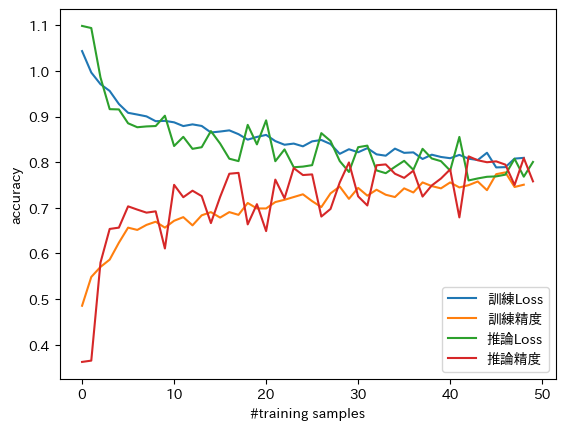

In [21]:
plt.figure()
df_train_loss_acc.plot()

plt.xlabel('#training samples')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
#plt.ylim([0, 1.01])
plt.show()

## ConfusionMatrix

In [22]:
load_weights = torch.load('model_weight.pth')
model.load_state_dict(load_weights)

<All keys matched successfully>

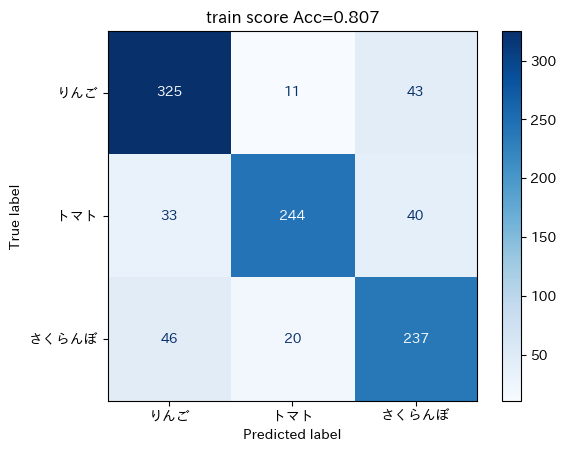

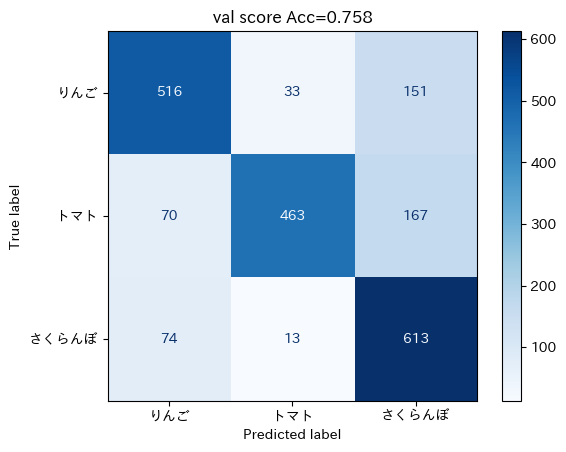

In [23]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true)
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()

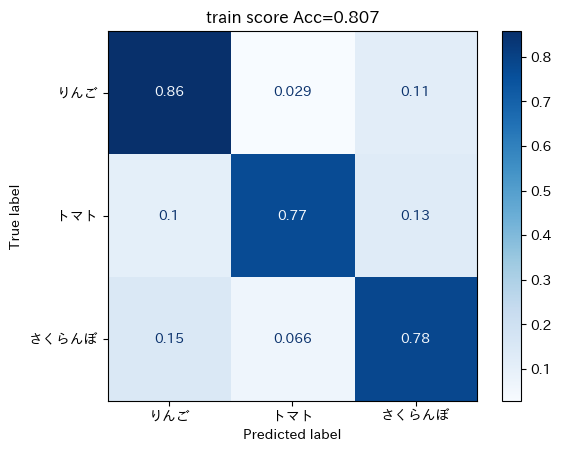

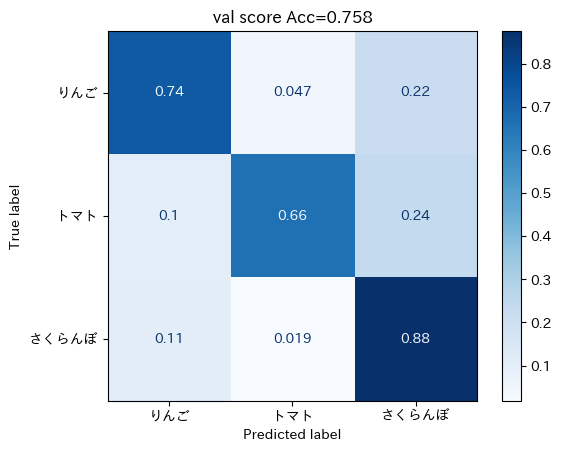

In [24]:
for phase, dataloader in dataloaders_dict.items():
  y_true = []
  y_pred = []

  for inputs, labels in dataloader:
    model.eval()
    with torch.set_grad_enabled(False):
      outputs = model.to('cpu')(inputs)
      _, preds = torch.max(outputs, 1)

    y_true.extend(labels.tolist())
    y_pred.extend(preds.tolist())

  #スコアの計算
  accuracy = accuracy_score(y_true, y_pred)

  #混合行列
  cm = confusion_matrix(y_pred = y_pred, y_true = y_true, normalize = "true")
  cmp = ConfusionMatrixDisplay(cm, display_labels = ["りんご", "トマト", "さくらんぼ"])
  cmp.plot(cmap = plt.cm.Blues)
  cmp.ax_.set_title(f"{phase} score Acc={accuracy:.3f}")
  plt.show()